# **TAREA 8 - VISIÓN DE MÁQUINA**

**Universidad Nacional de Colombia** <br>
**Maestría en Ingeniería - Automatización industrial**

Juan Sebastián Hernandez Reyes; Julián Felipe Molina Grisales

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import cv2

from skimage.filters import threshold_multiotsu

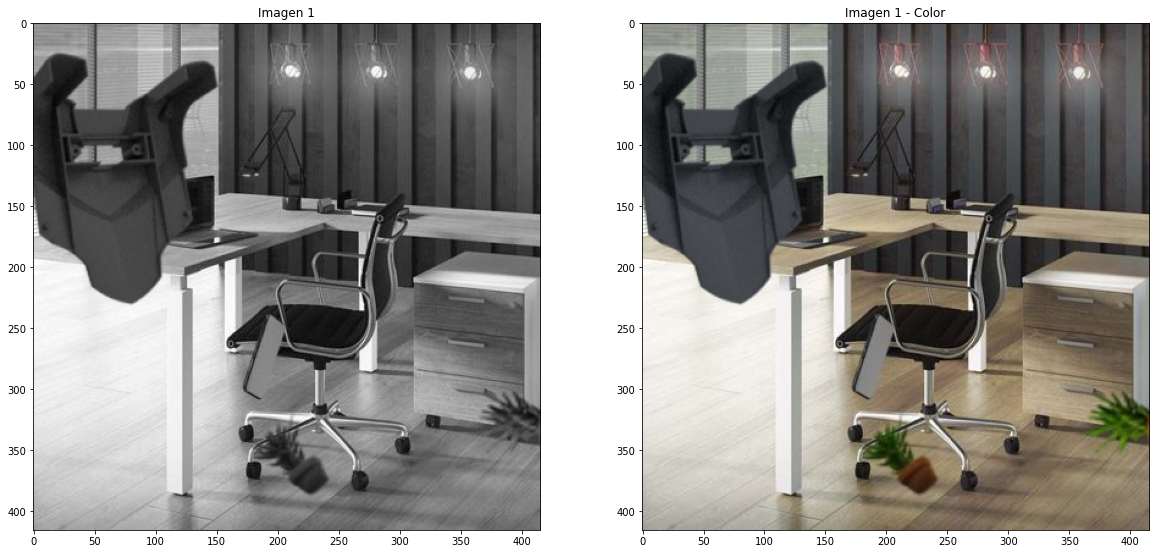

In [65]:
dir = '/content/drive/MyDrive/Colab Notebooks/Vision_Maquina/Tarea8 - Segmentacion/imagen.png'

img1 = cv2.imread(dir,0)        

img1_C = cv2.cvtColor(cv2.imread(dir,1),cv2.COLOR_BGR2RGB) 

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[20,10])
ax1.imshow(img1, cmap=plt.cm.gray), 
ax1.set_title('Imagen 1')
ax2.imshow(img1_C, cmap=plt.cm.gray), 
ax2.set_title('Imagen 1 - Color')
plt.show()

## 1. Implementar el algoritmo de umbralización multinivel de Otsu


---

---


In [18]:
# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(img1)

# Using the threshold values, we generate the three regions.
regions = np.digitize(img1, bins=thresholds)

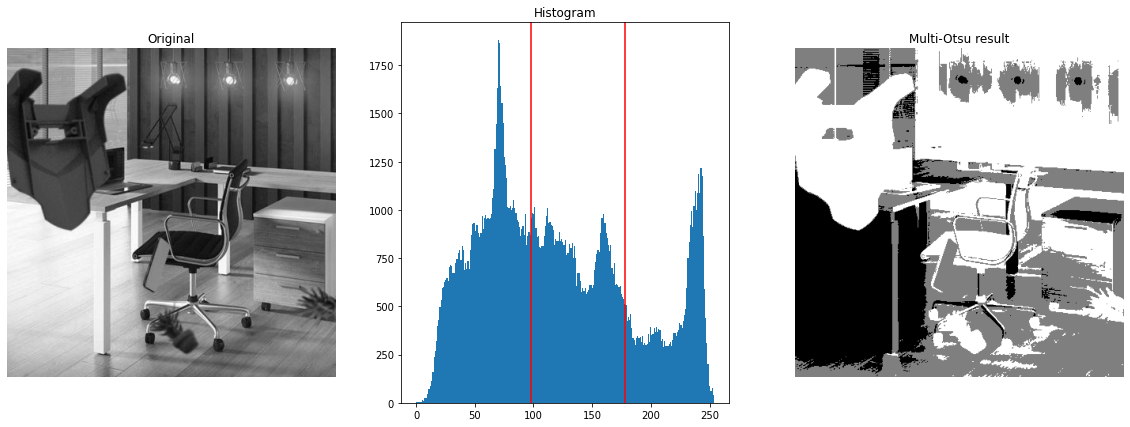

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))

# Plotting the original image.
ax[0].imshow(img1, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ravel = img1.ravel()
ax[1].hist(ravel, bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='gray_r')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

## 2. Estudiar las técnicas de segmentación vistas hasta ahora al ser usadas en imágenes de su proyecto.
---

---




### Segmentación basada en umbrales



#### Umbralización

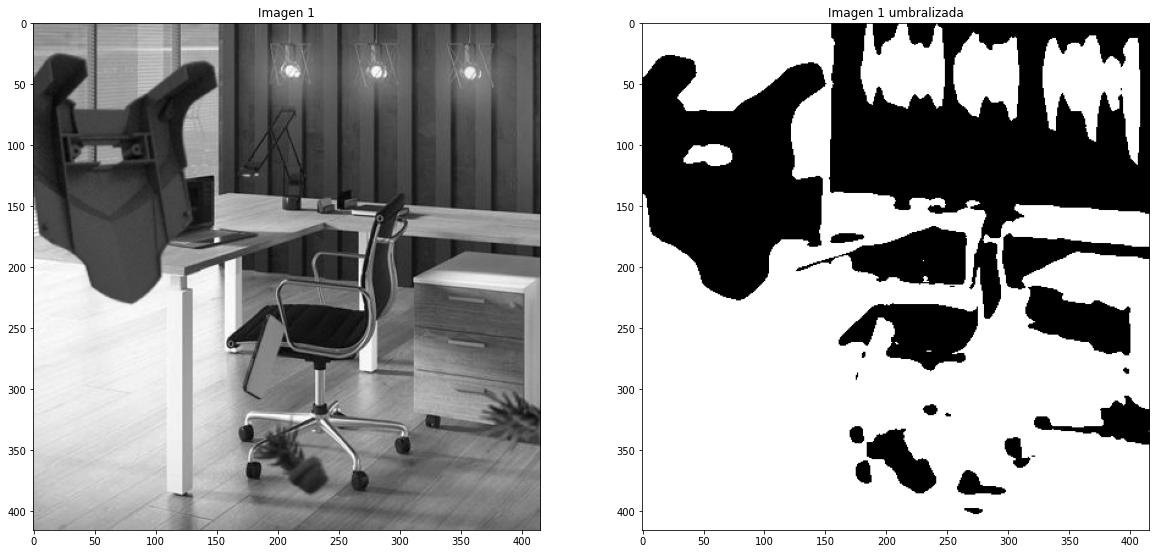

In [28]:
# Imagenes gausianas
gray1 = cv2.GaussianBlur(img1, (7, 7), 3)

# Umbralización
t, dst1 = cv2.threshold(gray1, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_TRIANGLE)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[20,10])
ax1.imshow(img1, cmap=plt.cm.gray)
ax1.set_title('Imagen 1')

ax2.imshow(dst1, cmap=plt.cm.gray)
ax2.set_title('Imagen 1 umbralizada')
plt.show()

#### Umbralización adaptativa

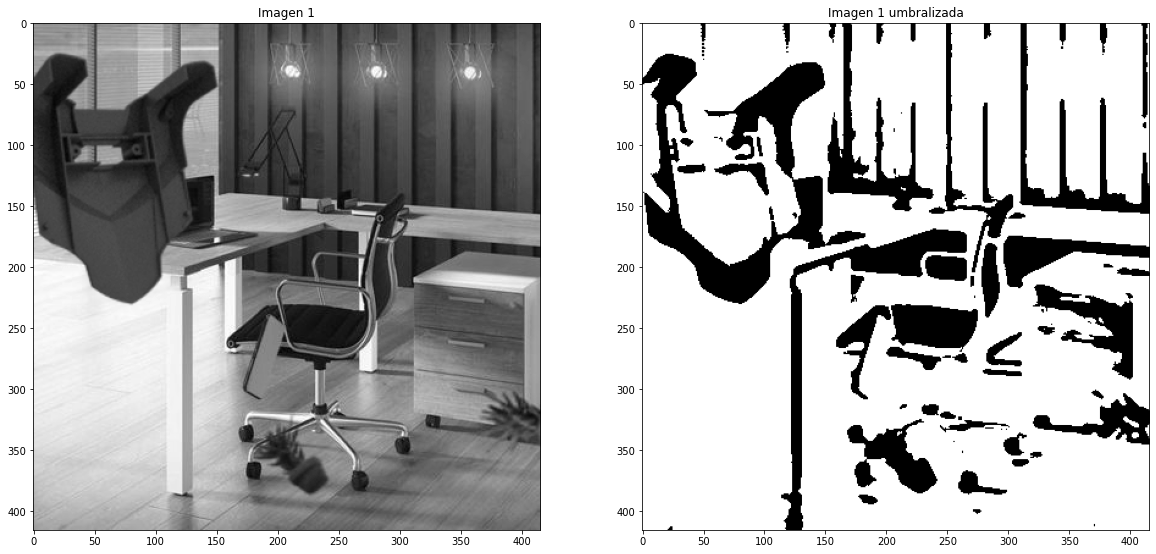

In [57]:
# Imagenes gausianas
gray1 = cv2.medianBlur(img1, 5)

# Umbralización adaptativa
dst1 = cv2.adaptiveThreshold(gray1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 121, 20)

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[20,10])
ax1.imshow(img1, cmap=plt.cm.gray)
ax1.set_title('Imagen 1')

ax2.imshow(dst1, cmap=plt.cm.gray)
ax2.set_title('Imagen 1 umbralizada')
plt.show()

### Segmentación basada en regiones

#### Contornos

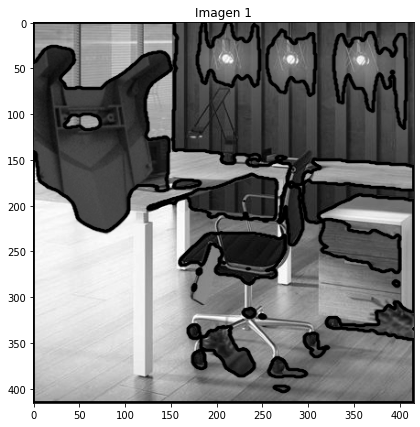

In [58]:
gray1 = cv2.GaussianBlur(img1, (7, 7), 3)

t, dst1 = cv2.threshold(gray1, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_TRIANGLE)

# Contornos
contours, hierarchy = cv2.findContours(dst1, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

image = cv2.drawContours(img1, contours, -1, (0, 255, 0), 2, cv2.LINE_AA)

fig, ax = plt.subplots(figsize=(20, 7))
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Imagen 1')
plt.show()



### Canny

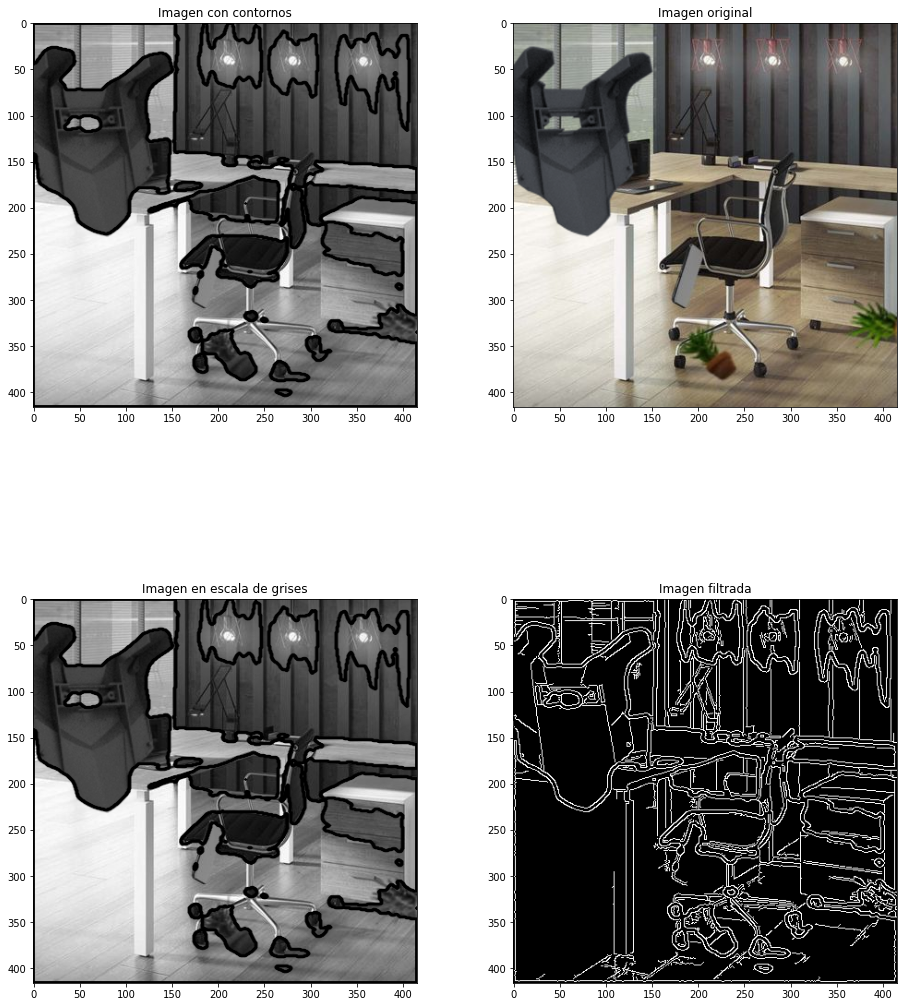

In [59]:
gray1 = img1
edged1 = cv2.Canny(gray1, 50, 150, apertureSize = 3)
    
plt.subplot(221),plt.imshow(image, cmap=plt.cm.gray), plt.title('Imagen con contornos')
plt.subplot(222), plt.imshow(img1_C, cmap=plt.cm.gray), plt.title('Imagen original')
plt.subplot(223), plt.imshow(gray1, cmap=plt.cm.gray), plt.title('Imagen en escala de grises')
plt.subplot(224), plt.imshow(edged1, cmap=plt.cm.gray), plt.title('Imagen filtrada')


# Adjust the subplot layout, because the logit one may take more space
# than usual, due to labels 
plt.subplots_adjust(top=1.1, bottom=-2.5, left=-0.5, right=1.5, hspace=0.25, wspace=0.25)

plt.show()

Para imagenes con líneas de poca longitud, no se logra el efecto deseado, esto se debe principalmente a la imagen obtenida con el filtro de Canny, la cual no es muy clara, ya que se ha perdido información.

### Watershed

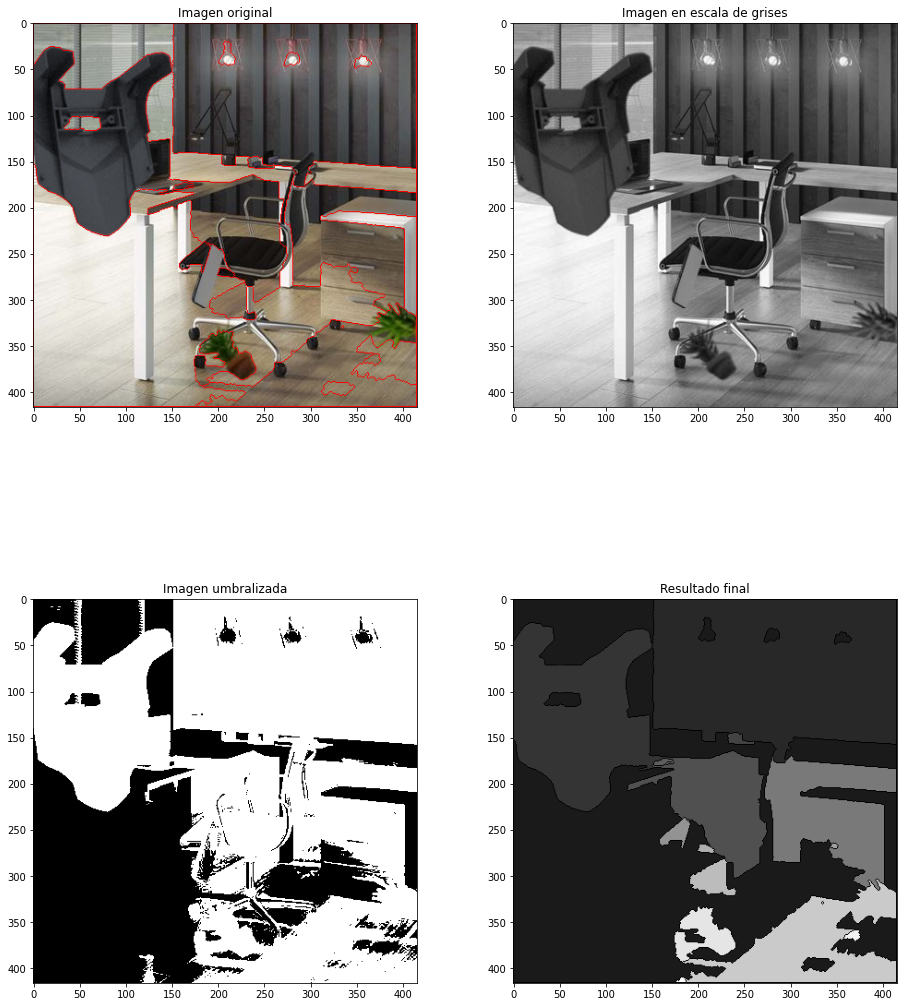

In [67]:
img1 = cv2.imread(dir,0)    
gray1 = img1  
ret, thresh = cv2.threshold(img1,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Eliminación del ruido
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# Encuentra el área del fondo
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Encuentra el área del primer
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,3)
ret, sure_fg = cv2.threshold(dist_transform,0.1*dist_transform.max(),255,0)

# Encuentra la región desconocida (bordes)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

# Etiquetado
ret, markers = cv2.connectedComponents(sure_fg)

# Adiciona 1 a todas las etiquetas para asegurra que el fondo sea 1 en lugar de cero
markers = markers+1

# Ahora se marca la región desconocida con ceros
markers[unknown==255] = 0

# Watershed
markers = cv2.watershed(img1_C,markers)
img1_C[markers == -1] = [255,0,0]

plt.subplot(221), plt.imshow(img1_C), plt.title('Imagen original')
plt.subplot(222), plt.imshow(gray1, cmap=plt.cm.gray), plt.title('Imagen en escala de grises')
plt.subplot(223), plt.imshow(thresh, cmap=plt.cm.gray), plt.title('Imagen umbralizada')
plt.subplot(224), plt.imshow(markers, cmap=plt.cm.gray), plt.title('Resultado final')

# Adjust the subplot layout, because the logit one may take more space
# than usual, due to labels 
plt.subplots_adjust(top=1.1, bottom=-2.5, left=-0.5, right=1.5, hspace=0.25, wspace=0.25)

plt.show()

## 3. Implemente, como función de Python, dos de la métricas de evaluación de la segmentación presentadas.

---

---


In [ ]:
from skimage.metrics import (adapted_rand_error,
                              variation_of_information)

## 4. Evalúe, con las métricas implementadas, al menos un algoritmo de cada categoría de segmentación. Excluya de esta evaluación la categoría de segmentación por matching.
---

---



## Method: Referencia
Adapted Rand error: 0.0
Adapted Rand precision: 1.0
Adapted Rand recall: 1.0
Over-segmentation: 1.417610784431079e-16
Under-segmentation: 1.417610784431079e-16

## Method: Regiones(piramidal)
Adapted Rand error: 0.1342390320647986
Adapted Rand precision: 0.9191453639514797
Adapted Rand recall: 0.8182373565557188
Over-segmentation: 0.29468045685366445
Under-segmentation: 1.0920789428029498

## Method: Bordes(canny)
Adapted Rand error: 0.12541787890502265
Adapted Rand precision: 0.9367406635117111
Adapted Rand recall: 0.8201594630846821
Over-segmentation: 0.25612406041504115
Under-segmentation: 1.0857291162632445

## Method: Umbrales(Otsu)
Adapted Rand error: 0.12966239252465828
Adapted Rand precision: 0.9017315229236212
Adapted Rand recall: 0.8410561152590198
Over-segmentation: 0.36113428008745946
Under-segmentation: 1.0502220992527498


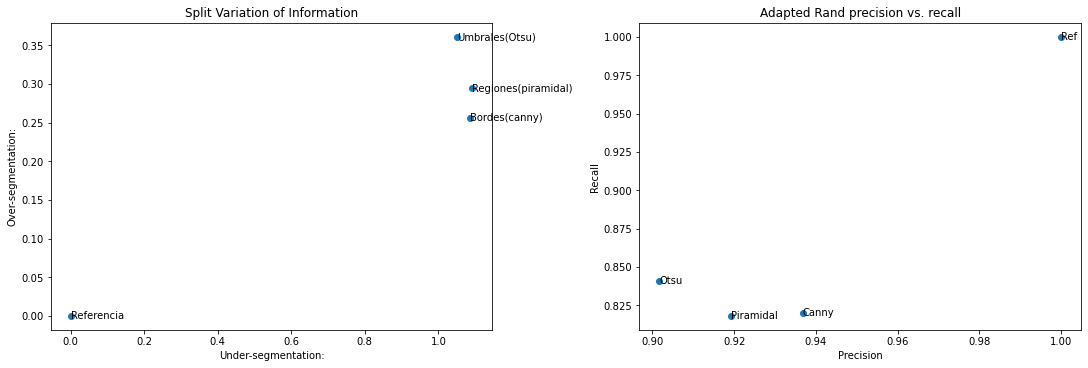

In [ ]:
precision_list = []
recall_list = []
split_list = []
merge_list = []
for name, im_test in zip(names, results):
    error, precision, recall = adapted_rand_error(borderRef, im_test)
    splits, merges = variation_of_information(borderRef, im_test)
    split_list.append(splits)
    merge_list.append(merges)
    precision_list.append(precision)
    recall_list.append(recall)
    print(f"\n## Method: {name}")
    print(f"Adapted Rand error: {error}")
    print(f"Adapted Rand precision: {precision}")
    print(f"Adapted Rand recall: {recall}")
    print(f"Over-segmentation: {splits}")
    print(f"Under-segmentation: {merges}")

## Referencias

1.   Notas de clase y presentaciones. Visión de máquina. 2021-I.
2.   Multi-Otsu Thresholding. scikit-image API. Available [here](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_multiotsu.html)
